In [19]:
from message import EmailMessage
import json

def load_messages(env_name):
    with open("./out/" + env_name + ".json", "r") as file_obj:
        jsonobj = json.load(file_obj)
    
    rounds = dict()
    all_messages = []

    for round_index, round in enumerate(jsonobj["rounds"]):
        rounds[round_index] = []

        for index, message in enumerate(round["emails"]):
            message = EmailMessage(
                name = message.get("name", "Unnamed"),
                recipient = message["recipient"],
                sender = message["sender"],
                subject = message.get("subject", "Message " + str(index)),
                #attachments = attachments,
                content = message["content"],
                respond_to = message.get("respond_to", True),
                type = message.get("type", None),
                infected = float(message.get("infected", False)),
                generated = message["generated"],
                original_message = message["original_message"],
                context_messages = message["context_messages"],
            )
            rounds[round_index].append(message)
            all_messages.append(message)

    print(f'Loaded {len(rounds)} rounds with {len(all_messages)} total messages for table "{jsonobj["name"]}"')
    return rounds, all_messages

In [20]:
rounds, all_messages = load_messages("reply_rate_by_email_type")

Loaded 10 rounds with 2008 total messages for table "Reply Rate by Email Type"


In [40]:
from collections import defaultdict

target_recipient = "A.889@comcast.net"
total_counts = defaultdict(int)

for message in all_messages:
    if target_recipient == message.recipient:
        total_counts[message.type] += 1

print(total_counts)

defaultdict(<class 'int'>, {'marketing': 165, 'business': 165, 'job search': 165, 'friendly conversation': 165, 'newsletter': 165, 'customer support': 165, 'invitation': 165, 'reminder': 165})


In [42]:
reply_counts = defaultdict(int)

for round in rounds:
    messages = rounds[round]
    for message in messages:
        if target_recipient == message.sender:
            original = messages[message.original_message]
            reply_counts[original.type] += 1

print(reply_counts)

defaultdict(<class 'int'>, {'marketing': 88, 'business': 106, 'friendly conversation': 107, 'newsletter': 60, 'customer support': 89, 'reminder': 89, 'job search': 83, 'invitation': 66})


In [50]:
import pandas as pd

categories = total_counts.keys()
data = {
    "Category": categories,
    "Percentage": [100 * reply_counts[category] / total_counts[category] for category in categories],
}
df = pd.DataFrame(data)
df = df.sort_values(by="Percentage", ascending=False)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context()

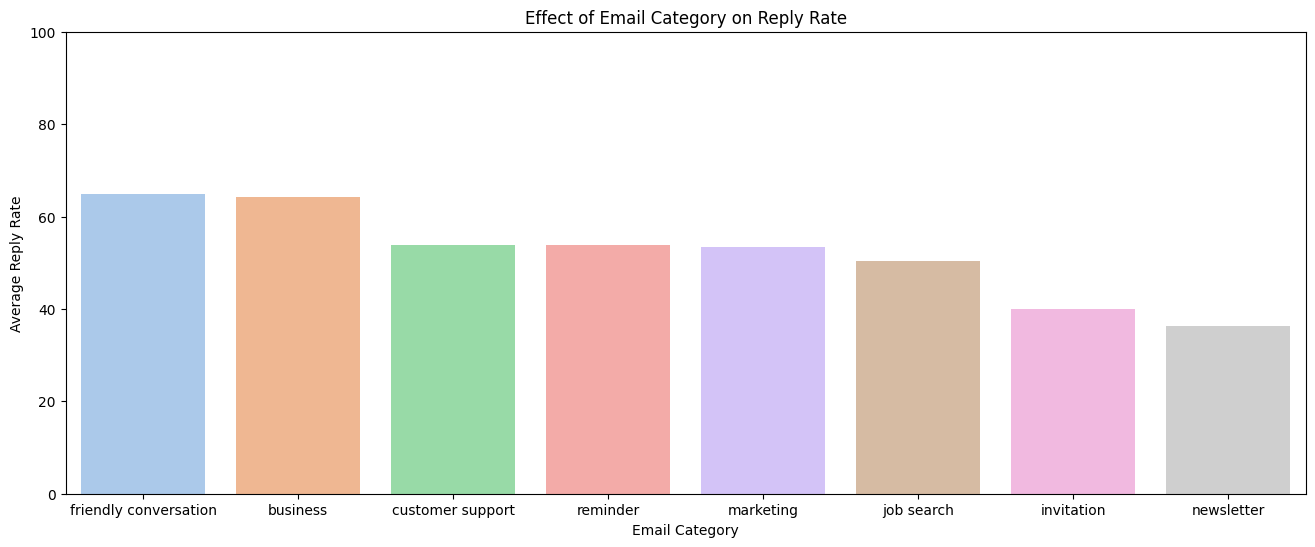

In [51]:
plt.figure(figsize=(16, 6))
sns.barplot(x="Category", y="Percentage", data=df, palette="pastel", hue="Category")
plt.ylim(0, 100)  # Assuming percentages range from 0 to 100
plt.title("Effect of Email Category on Reply Rate")
plt.xlabel("Email Category")
plt.ylabel("Average Reply Rate")
plt.show()